# Computes overall preference for the light source location

Generates __figures 2-3__, __table 1__, and corresponding statistical comparisons

In [1]:
rm(list= ls())

In [11]:
library(dplyr)
library(ggplot2)
library(binom)
library(lmerTest)
library(effsize)

## Loading results

In [3]:
results= read.csv2(file.path('Data', 'results_with_estimates.csv'), sep=';', dec='.', stringsAsFactors=FALSE)
results$Observer <- as.factor(results$Observer)

## Overall summary table on individual observers
__Table S1__ in the manuscript

In [4]:
trials.per.participant <- results %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(total.trials= n(),
                     proportion.of.trials.with.an.estimate= 100*sum(Confidence>0)/total.trials,
                     estimate.on.left.CI.lower= 100*binom::binom.exact(sum(sign(true_angle[Confidence>0])==-1), sum(Confidence>0), conf.level = 0.99)$lower,
                     estimate.on.left.mean= 100*mean(sign(true_angle[Confidence>0])==-1),
                     estimate.on.left.CI.upper= 100*binom::binom.exact(sum(sign(true_angle[Confidence>0])==-1), sum(Confidence>0), conf.level = 0.99)$upper,
                     relative.orientation= mean(abs(true_angle[Confidence>0])*180/pi),
                     relative.orientation.sd= sd(abs(true_angle[Confidence>0])*180/pi),
                     confidence.mean= mean(Confidence[Confidence>0]),
                     confidence.sd= sd(Confidence[Confidence>0])
                     )

trials.per.participant

Observer,total.trials,proportion.of.trials.with.an.estimate,estimate.on.left.CI.lower,estimate.on.left.mean,estimate.on.left.CI.upper,relative.orientation,relative.orientation.sd,confidence.mean,confidence.sd
HHA96w,4882,71.32323,63.68966,65.79552,67.85784,55.26242,22.99811,4.790063,0.8783417
IKB95w,1270,76.22047,64.29666,68.28512,72.09102,55.58514,19.77754,5.366736,1.3183962
KSC94w,63,76.19048,38.91170,58.33333,76.06580,71.02967,29.52144,4.145833,1.3044863
MMN92m,202,62.37624,50.88605,62.69841,73.52454,93.01582,39.37806,4.507937,0.9939500
SEF89m,248,85.08065,52.08020,61.13744,69.67960,72.43292,41.84831,4.018957,1.1950775
SKL94w,9358,87.61487,66.24614,67.59361,68.92054,39.12392,12.59931,4.717405,1.5708923
SSK93m,486,77.98354,58.57291,65.17150,71.38080,38.83322,23.33357,4.781003,1.0297470


## Plotting distributions of the _raw_ estimates
__Figures 1ACE__ in the manuscript.

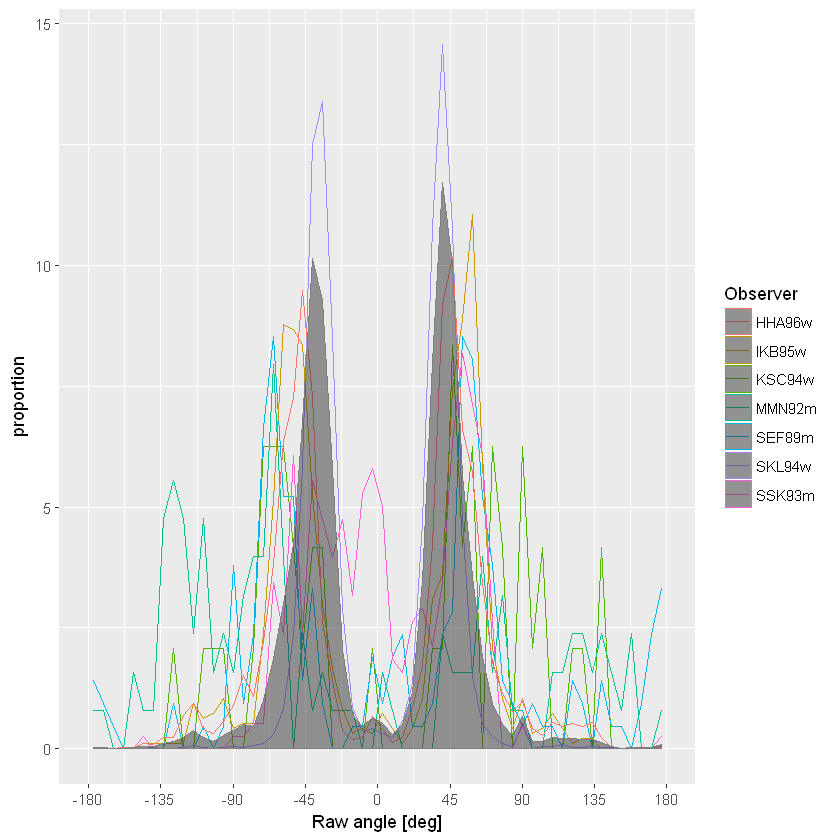

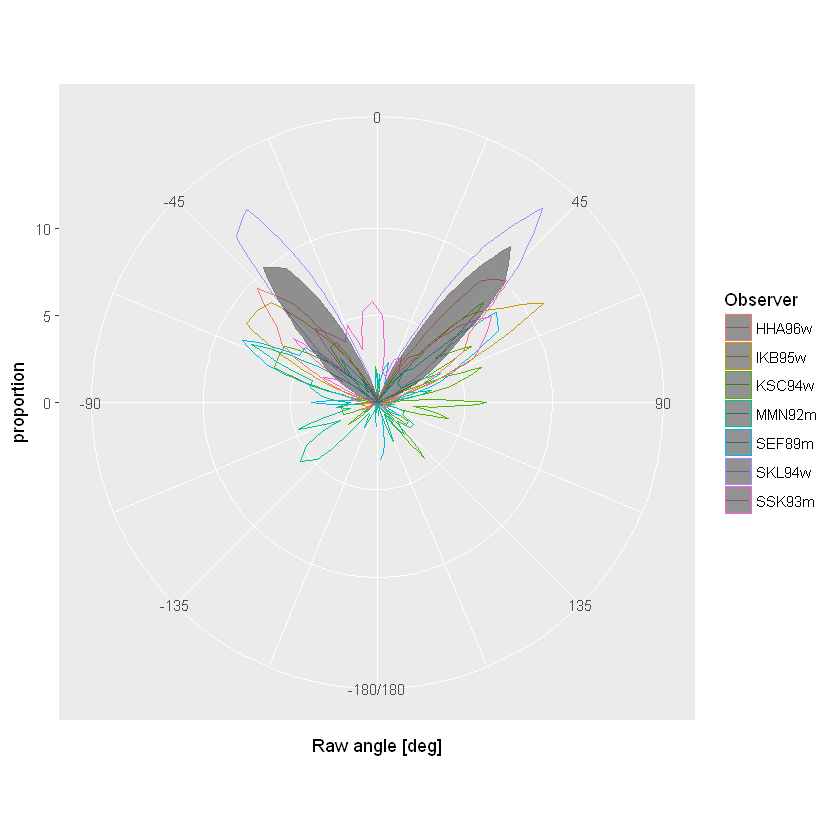

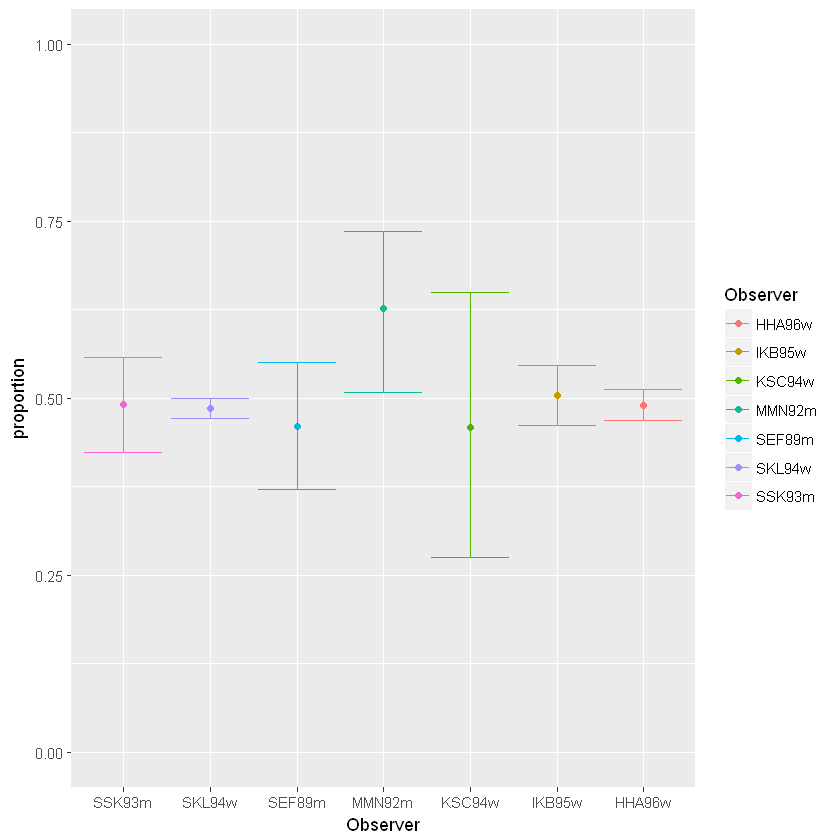

In [5]:
est.hist <- hist(results$angle, breaks = seq(-pi, pi, length.out= 59), plot=FALSE)
est.hist.df <- data.frame(angle= est.hist$mids, 
                          proportion= 100*est.hist$counts/sum(est.hist$counts))
                

observers.hist <- data.frame()
for(current.observer in unique(results$Observer)){
    current.hist <- hist(results$angle[results$Observer== current.observer], breaks = seq(-pi, pi, length.out= 59), plot=FALSE)
    
    observers.hist <- rbind(observers.hist,
                            data.frame(angle= current.hist$mids, 
                                       proportion= 100*current.hist$counts/sum(current.hist$counts),
                                       Observer= current.observer))
}

descartes.raw.plot <- ggplot(data= observers.hist, aes(x= angle, y= proportion, color= Observer)) + 
    geom_line()+
    geom_ribbon(data= est.hist.df, aes(ymin= 0, ymax= proportion, color= NA), alpha= 0.5)+
#     coord_polar(start = pi, direction=1) + 
    scale_x_continuous(breaks=seq(-pi, pi, length.out = 9), labels = seq(-180, 180, length.out = 9), lim= c(-pi, pi))+
    xlab('Raw angle [deg]')
print(descartes.raw.plot)
# ggsave(file="Generated figures/Raw angle - descartes.pdf", plot= descartes.raw.plot, width= 12, height= 8, units = 'cm')

polar.raw.plot <- ggplot(data= observers.hist, aes(x= angle, y= proportion, color= Observer)) + 
    geom_line()+
    geom_ribbon(data= est.hist.df, aes(ymin= 0, ymax= proportion, color= NA), alpha= 0.5)+
    coord_polar(start = pi, direction=1) + 
    scale_x_continuous(breaks=seq(-pi, pi, length.out = 9), labels = seq(-180, 180, length.out = 9), lim= c(-pi, pi))+
    xlab('Raw angle [deg]')
print(polar.raw.plot)
# ggsave(file="Generated figures/Raw angle - polar.pdf", plot= polar.raw.plot, width= 12, height= 8, units = 'cm')

# computing proportion to the left of the vertical
est.2.left <- results %>%
    dplyr::filter(Confidence > 0) %>%
    dplyr::mutate(est.2.left= angle<0) %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(count= sum(est.2.left),
                     proportion= mean(est.2.left), 
                     ci.lower= binom::binom.exact(count, n(), conf.level = 0.99)$lower,
                     ci.upper= binom::binom.exact(count, n(), conf.level = 0.99)$upper)

est.2.left.raw.plot <- ggplot(data= est.2.left, aes(x= Observer, y= proportion, 
                                                    ymin= ci.lower, ymax= ci.upper, 
                                                    color= Observer)) + 
    geom_errorbar() + 
    geom_point() + 
    scale_x_discrete(limits = rev(levels(results$Observer))) +
    ylim(0, 1)
    
print(est.2.left.raw.plot)
# ggsave(file="Generated figures/Raw angle - estimates proportion.pdf", plot= est.2.left.raw.plot, width= 12, height= 8, units = 'cm')

## Plotting distributions of the _corrected for mirroring_ estimates
__Figures 1BDG__ in the manuscript.

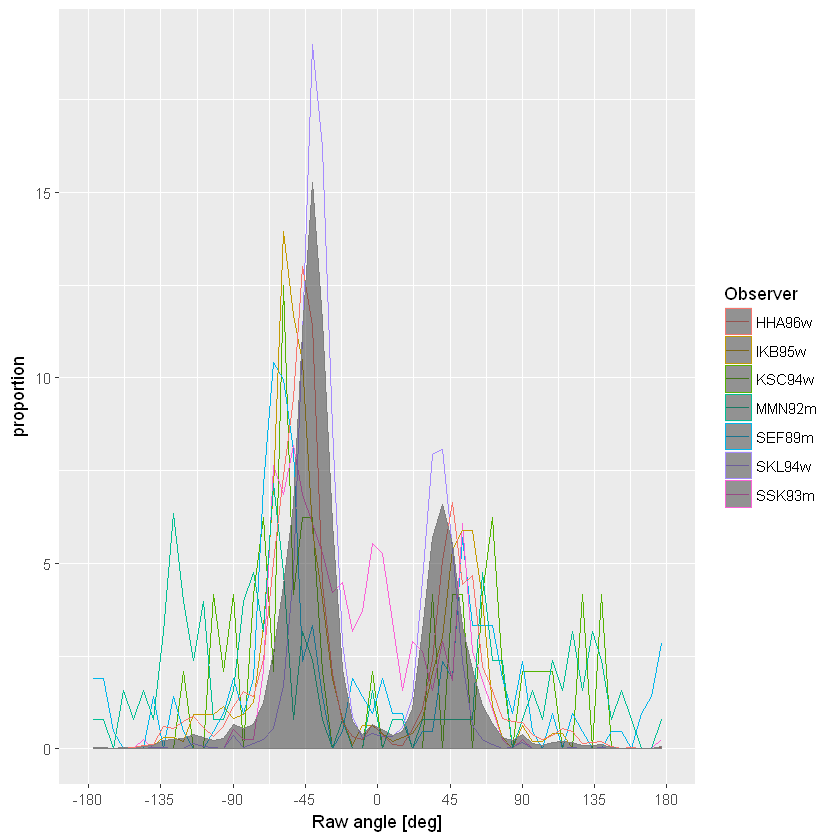

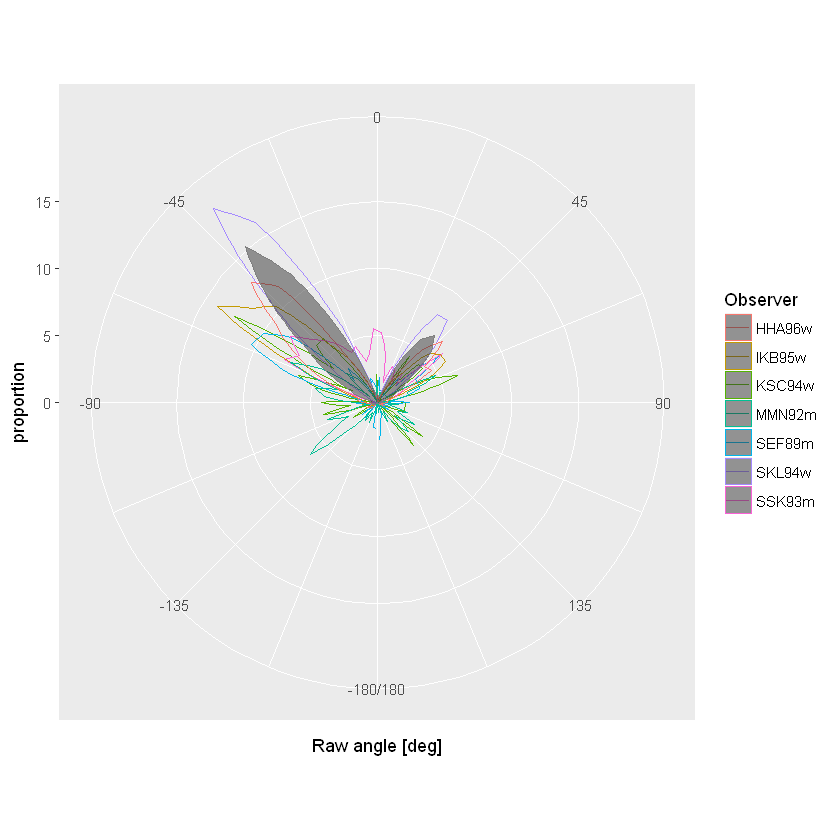

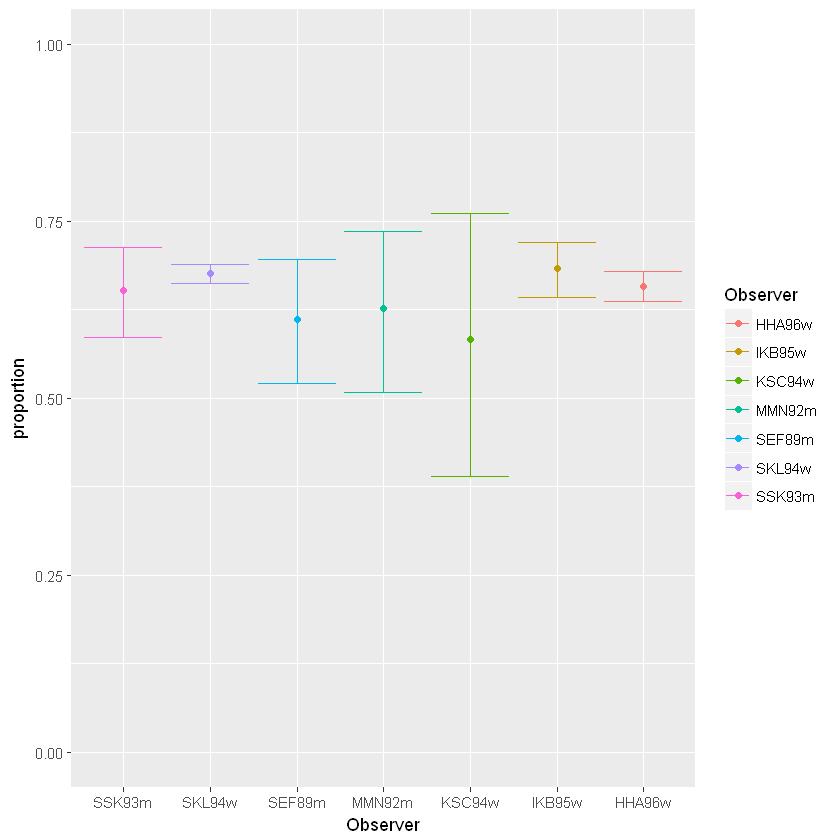

In [6]:
est.hist <- hist(results$true_angle, breaks = seq(-pi, pi, length.out= 59), plot=FALSE)
est.hist.df <- data.frame(angle= est.hist$mids, 
                          proportion= 100*est.hist$counts/sum(est.hist$counts))
                

observers.hist <- data.frame()
for(current.observer in unique(results$Observer)){
    current.hist <- hist(results$true_angle[results$Observer== current.observer], breaks = seq(-pi, pi, length.out= 59), plot=FALSE)
    
    observers.hist <- rbind(observers.hist,
                            data.frame(angle= current.hist$mids, 
                                       proportion= 100*current.hist$counts/sum(current.hist$counts),
                                       Observer= current.observer))
}

descartes.corr.plot <- ggplot(data= observers.hist, aes(x= angle, y= proportion, color= Observer)) + 
    geom_line()+
    geom_ribbon(data= est.hist.df, aes(ymin= 0, ymax= proportion, color= NA), alpha= 0.5)+
#     coord_polar(start = pi, direction=1) + 
    scale_x_continuous(breaks=seq(-pi, pi, length.out = 9), labels = seq(-180, 180, length.out = 9), lim= c(-pi, pi))+
    xlab('Raw angle [deg]')
print(descartes.corr.plot)
# ggsave(file="Generated figures/Corrected angle - descartes.pdf", plot= descartes.corr.plot, width= 12, height= 8, units = 'cm')


polar.corr.plot <- ggplot(data= observers.hist, aes(x= angle, y= proportion, color= Observer)) + 
    geom_line()+
    geom_ribbon(data= est.hist.df, aes(ymin= 0, ymax= proportion, color= NA), alpha= 0.5)+
    coord_polar(start = pi, direction=1) + 
    scale_x_continuous(breaks=seq(-pi, pi, length.out = 9), labels = seq(-180, 180, length.out = 9), lim= c(-pi, pi))+
    xlab('Raw angle [deg]')
print(polar.corr.plot)
# ggsave(file="Generated figures/Corrected angle - polar.pdf", plot= polar.corr.plot, width= 12, height= 8, units = 'cm')

# computing proportion to the RIGHT of the vertical
est.2.left <- results %>%
    dplyr::filter(Confidence > 0) %>%
    dplyr::mutate(est.2.left= true_angle<0) %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(count= sum(est.2.left),
                     proportion= mean(est.2.left), 
                     ci.lower= binom::binom.exact(count, n(), conf.level = 0.99)$lower,
                     ci.upper= binom::binom.exact(count, n(), conf.level = 0.99)$upper)

est.2.left.corr.plot <- ggplot(data= est.2.left, aes(x= Observer, y= proportion, 
                                                    ymin= ci.lower, ymax= ci.upper, 
                                                    color= Observer)) + 
    geom_errorbar() + 
    geom_point()+
    scale_x_discrete(limits = rev(levels(results$Observer))) +
    ylim(0, 1)
    
print(est.2.left.corr.plot)
# ggsave(file="Generated figures/Corrected angle - estimates proportion.pdf", plot= est.2.left.corr.plot, width= 12, height= 8, units = 'cm')

## Distributions of the relative angle
__Figure 1F__ in the manuscript

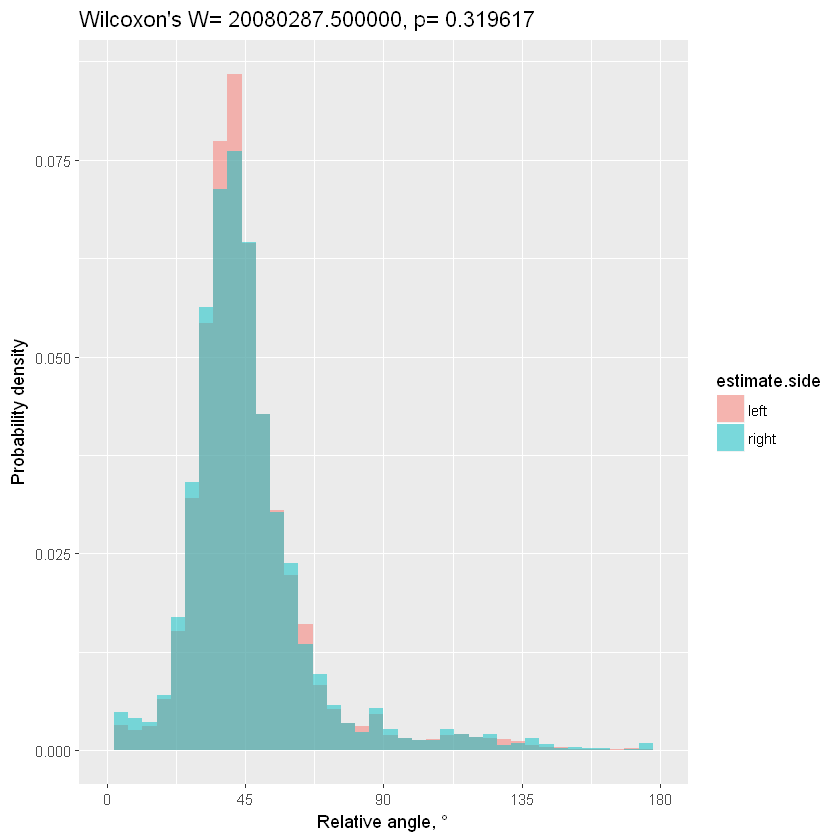

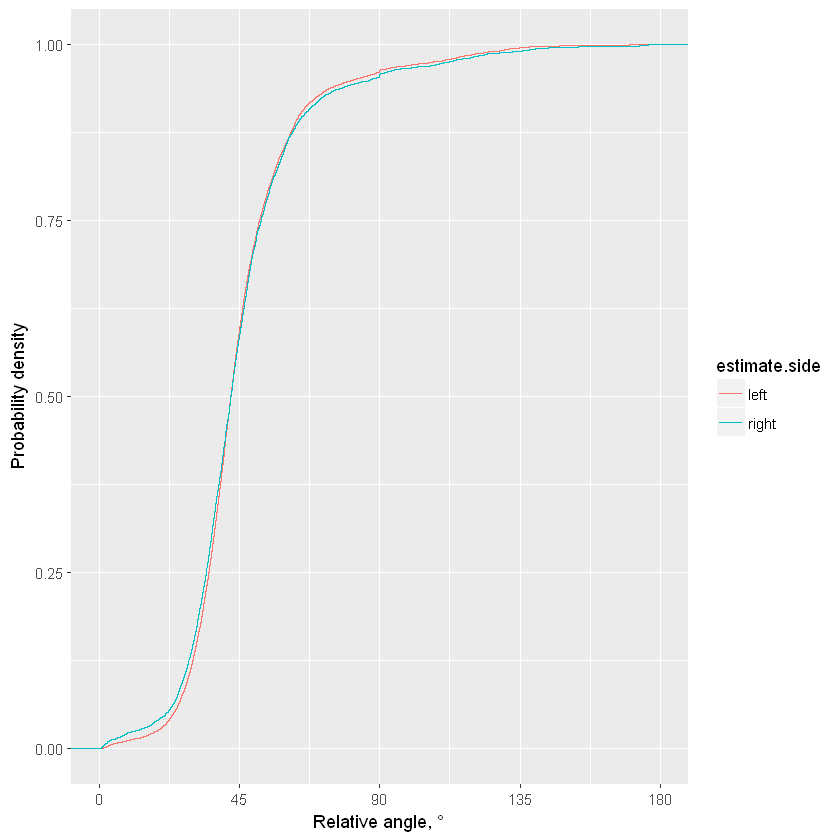

In [7]:
estimates <- results %>%
    dplyr::filter((Confidence > 0) & (true_angle!=0)) %>%
    dplyr::mutate(estimate.side= sign(true_angle),
                  relative.angle= abs(true_angle*180/pi),
                  estimate.side= factor(estimate.side, levels= c(-1, 1), labels= c('left', 'right')))

# dist.diff <- ks.test(estimates$relative.angle[estimates$estimate.side=='left'], estimates$relative.angle[estimates$estimate.side=='right'])

dist.diff<- wilcox.test(relative.angle ~ estimate.side, data= estimates)
    
relative.raw.plot <- ggplot(data= estimates, aes(x= relative.angle, fill= estimate.side)) + 
    geom_histogram(aes(y= ..density../sum(..density..)), bins= 40, alpha= 0.5, position="identity")+
#     stat_ecdf(geom = "step")+
    ylab("Probability density") + 
    xlab("Relative angle, °") + 
    scale_x_continuous(breaks= seq(0, 180, 45), limits = c(0, 180))+
#     ggtitle(sprintf('Kolmogorov-Smirnov D= %.2f, p= %g', dist.diff$statistic, dist.diff$p.value))
    ggtitle(sprintf("Wilcoxon's W= %f, p= %g", dist.diff$statistic, dist.diff$p.value))
print(relative.raw.plot)
# ggsave(file="Generated figures/Relative angle - pdf.pdf", plot= relative.raw.plot, width= 12, height= 8, units = 'cm')

cdf.raw.plot <- ggplot(data= estimates, aes(x= relative.angle, color= estimate.side)) + 
    stat_ecdf(geom = "step")+
    ylab("Probability density") + 
    xlab("Relative angle, °")+
    scale_x_continuous(breaks= seq(0, 180, 45), limits = c(0, 180))
print(cdf.raw.plot)
# ggsave(file="Generated figures/Relative angle - cdf.pdf", plot= cdf.raw.plot, width= 12, height= 8, units = 'cm')

## Confidence distribution
__Figure S3A__ in the manuscript

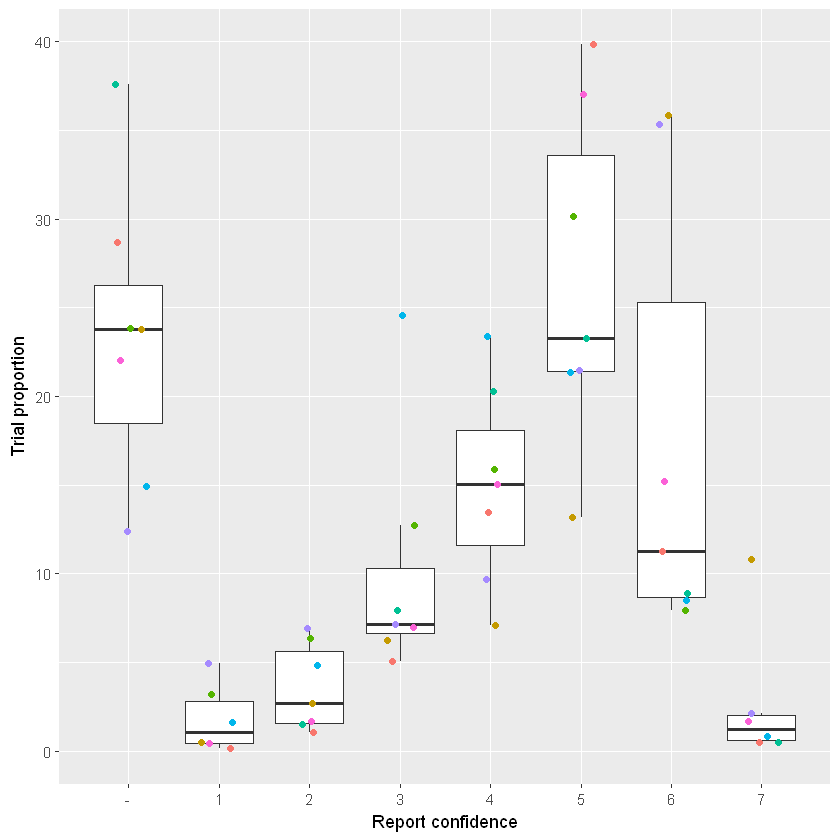

In [8]:
conf.dist <- results %>%
    dplyr::group_by(Observer, Confidence) %>%
    dplyr::summarize(count= n()) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Observer) %>%
    dplyr::mutate(count = 100*count/sum(count))

conf.plot <- ggplot(data= conf.dist, aes(x= Confidence, y= count, color= Observer, group= Confidence)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(width= 0.2) + 
    ylab('Trial proportion') + 
    xlab('Report confidence') + 
    scale_x_continuous(breaks= 0:7, labels = c('-', 1:7)) + 
    theme(panel.grid.minor.x = element_blank(), legend.position = 'none')

print(conf.plot)
# ggsave(file="Generated figures/Response confidence.pdf", plot= conf.plot, width= 8, height= 8, units = 'cm')

## Consistency as the function of confidence
__Figure S3B__ in the manuscript.


Call:
lm(formula = estimate.std ~ confidence, data = paintings)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.219 -15.698  -6.627  12.384 109.475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  70.9093     5.0920  13.926   <2e-16 ***
confidence   -8.7912     0.9954  -8.832   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22.28 on 745 degrees of freedom
Multiple R-squared:  0.09478,	Adjusted R-squared:  0.09356 
F-statistic:    78 on 1 and 745 DF,  p-value: < 2.2e-16


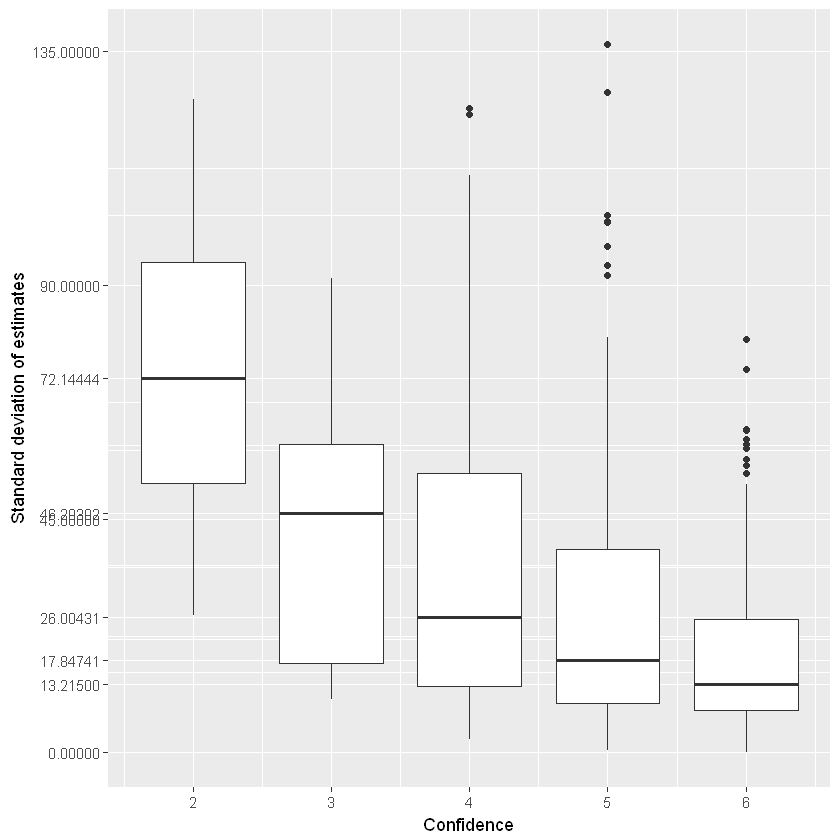

In [9]:
paintings <- results %>%
    dplyr::filter(Confidence>0) %>%
    dplyr::group_by(local_filename) %>%
    dplyr::filter(n()>2) %>%
    dplyr::summarize(estimate.std= sd(true_angle*180/pi, na.rm= TRUE),
                     confidence= round(mean(Confidence)))

mean.per.confidence.level <- paintings %>%
    group_by(confidence) %>%
    summarize(median.std= median(estimate.std))

# paintings

confidence.vs.variance.plot <- ggplot(data= paintings, aes(x= confidence, y= estimate.std, group= confidence)) + 
    geom_boxplot() + 
    xlab('Confidence') +
    ylab('Standard deviation of estimates') + 
    scale_y_continuous(breaks= c(seq(0, 180, 45), mean.per.confidence.level$median.std))
print(confidence.vs.variance.plot)
# ggsave(file="Generated figures/Estimates consistency based on confidence.pdf", plot= confidence.vs.variance.plot, width= 8, height= 8, units = 'cm')

summary(lm(estimate.std ~ confidence , data= paintings))

## Computing an average estimate for each painting
This is then used as for the classifier script

In [10]:
paintings.with.an.estimate <- results %>%
    dplyr::filter(Confidence>0, year_unambiguous>1000) %>%
    dplyr::group_by(local_filename) %>%
    dplyr::summarize(year= year_unambiguous[1], 
                     estimate= mean(true_angle), 
                     estimate.side= sign(estimate),
                     confidence= mean(Confidence))
write.csv2(paintings.with.an.estimate, file.path('Data', 'paintings with estimates.csv'), row.names= FALSE)